# **Importing Necessary Modules**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import lime
from lime import lime_tabular
import shap
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import warnings
warnings.filterwarnings("ignore")


2025-05-03 15:33:27.619497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746286407.808242      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746286407.859702      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Loading**

In [3]:
classes, class_paths = zip(*[(label, os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training', label, image))
                             for label in os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training') if os.path.isdir(os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training', label))
                             for image in os.listdir(os.path.join('/kaggle/input/brain-tumor-mri-dataset/Training', label))])

tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [4]:
classes, class_paths = zip(*[(label, os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing', label, image))
                             for label in os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing') if os.path.isdir(os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing', label))
                             for image in os.listdir(os.path.join('/kaggle/input/brain-tumor-mri-dataset/Testing', label))])

ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


# **Exploratory Data Analysis**

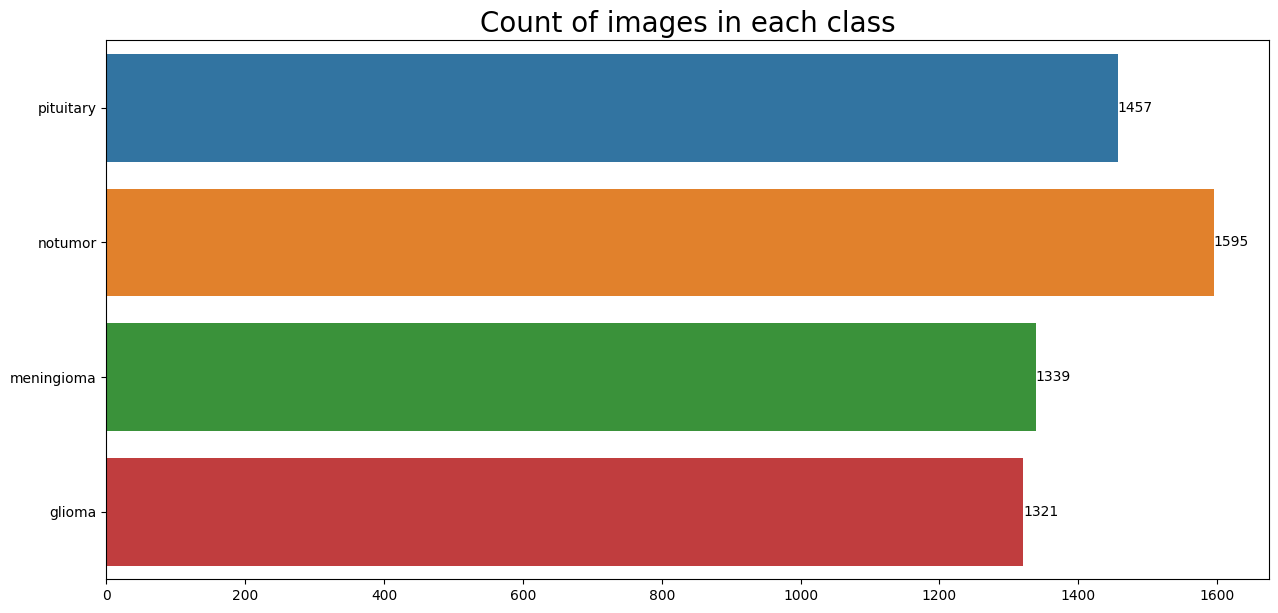

In [5]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

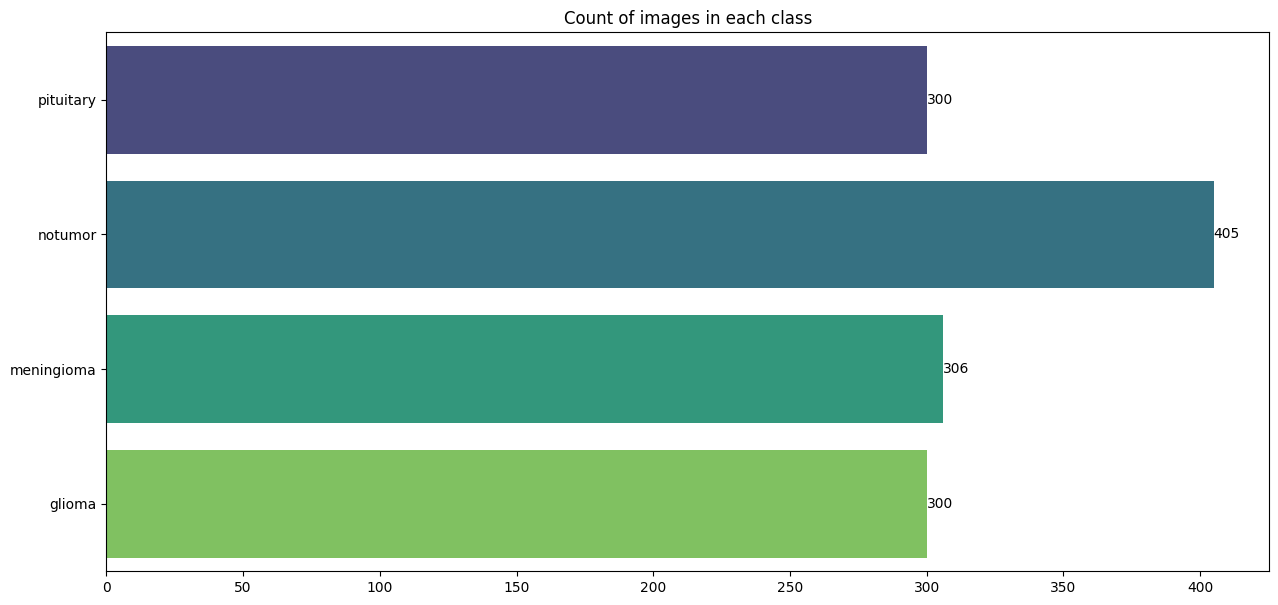

In [6]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [7]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [8]:
batch_size = 32
img_size = (224, 224)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


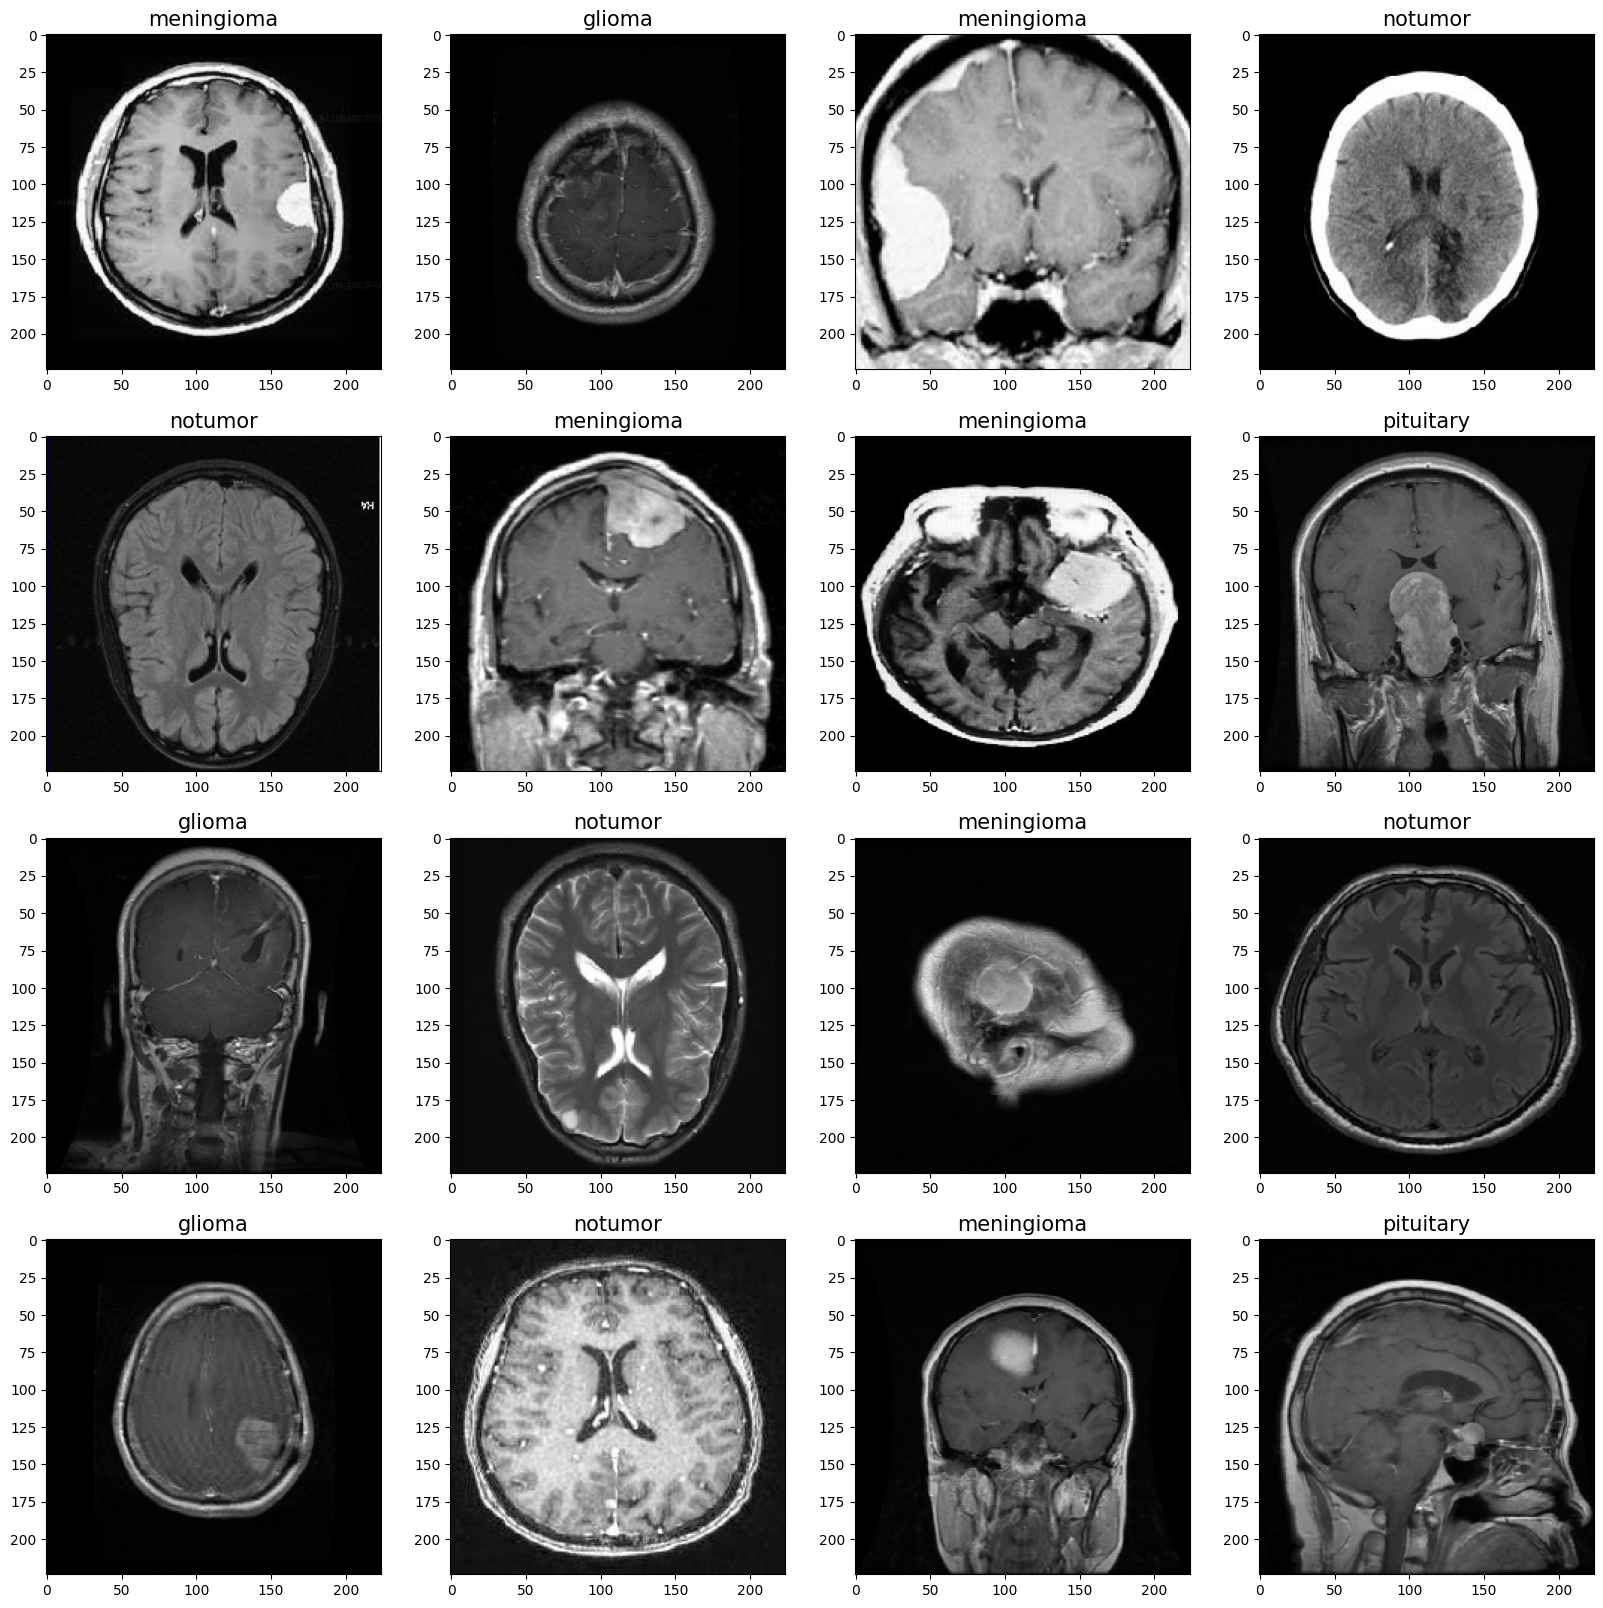

In [9]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# **Training EfficientNetB0 To Use It As Our Feature Extractor**

In [13]:
img_shape=(224,224,3)

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Functional API
x = base_model.output
x = Flatten()(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()],
)

# Print model summary
model.summary()

I0000 00:00:1746286708.636787      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 4,172,032 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 callbacks = callbacks,
                 shuffle= False)

Epoch 1/10


I0000 00:00:1746286777.073075      96 service.cc:148] XLA service 0x7bc9480034d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746286777.074026      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746286781.006331      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1746286789.770442      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746286789.959409      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746286790.432701      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746286790.6396

178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7330 - loss: 1.4610 - precision: 0.7412 - recall: 0.7252

E0000 00:00:1746286858.457307      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746286858.642727      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746286859.077522      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746286859.282747      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746286859.631346      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7335 - loss: 1.4566 - precision: 0.7417 - recall: 0.7257
Epoch 1: val_accuracy improved from -inf to 0.32061, saving model to best_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 170s 486ms/step - accuracy: 0.7341 - loss: 1.4523 - precision: 0.7423 - recall: 0.7263 - val_accuracy: 0.3206 - val_loss: 1.9055 - val_precision: 0.2500 - val_recall: 0.0046 - learning_rate: 0.0010
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9104 - loss: 0.2542 - precision: 0.9203 - recall: 0.9030
Epoch 2: val_accuracy did not improve from 0.32061
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - accuracy: 0.9105 - loss: 0.2539 - precision: 0.9204 - recall: 0.9031 - val_accuracy: 0.2504 - val_loss: 2.0721 - val_precision: 0.2574 - val_recall: 0.2244 - learning_rate: 0.0010
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9508 - loss: 0.1391 - precision: 0.9540 - recall: 0.9449
Epoch 3: val_accuracy improved from 0.32061 to

**Plotting Results**

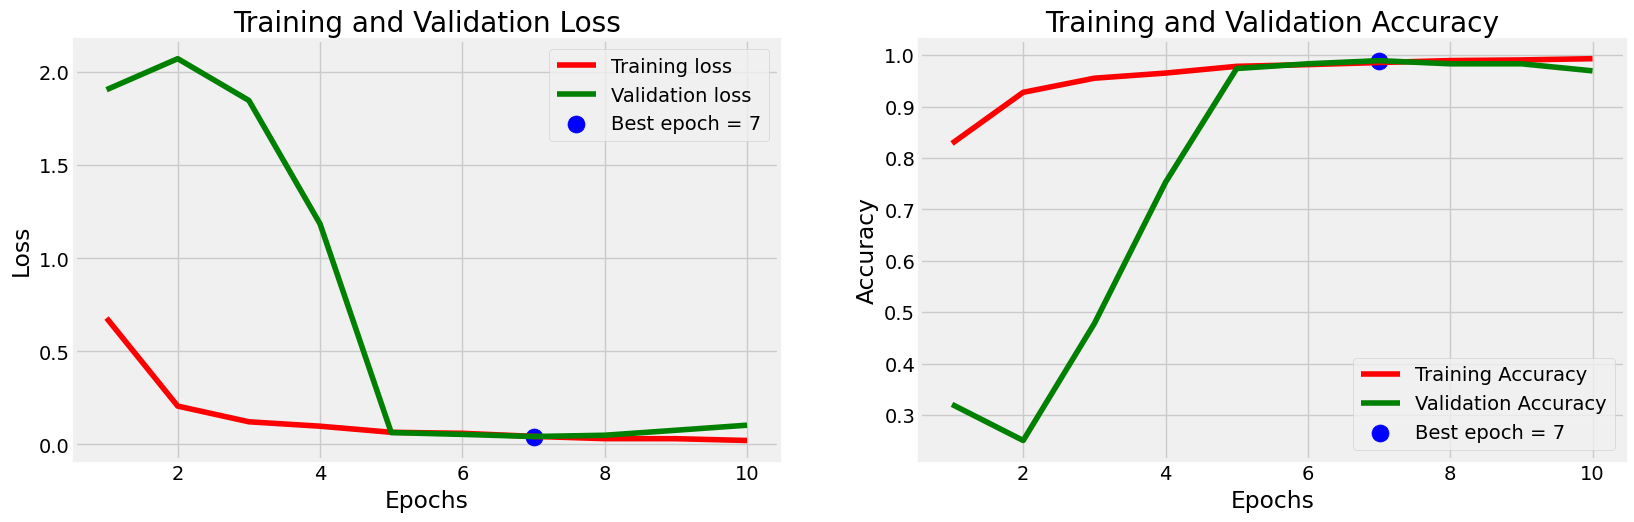

In [15]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [16]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.9994 - loss: 0.0050 - precision: 0.9996 - recall: 0.9994
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9918 - loss: 0.0338 - precision: 0.9918 - recall: 0.9918
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9918 - loss: 0.0260 - precision: 0.9932 - recall: 0.9918
Train Loss: 0.0047
Train Accuracy: 99.93%
--------------------
Validation Loss: 0.0444
Validation Accuracy: 98.78%
--------------------
Test Loss: 0.0497
Test Accuracy: 98.63%


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step


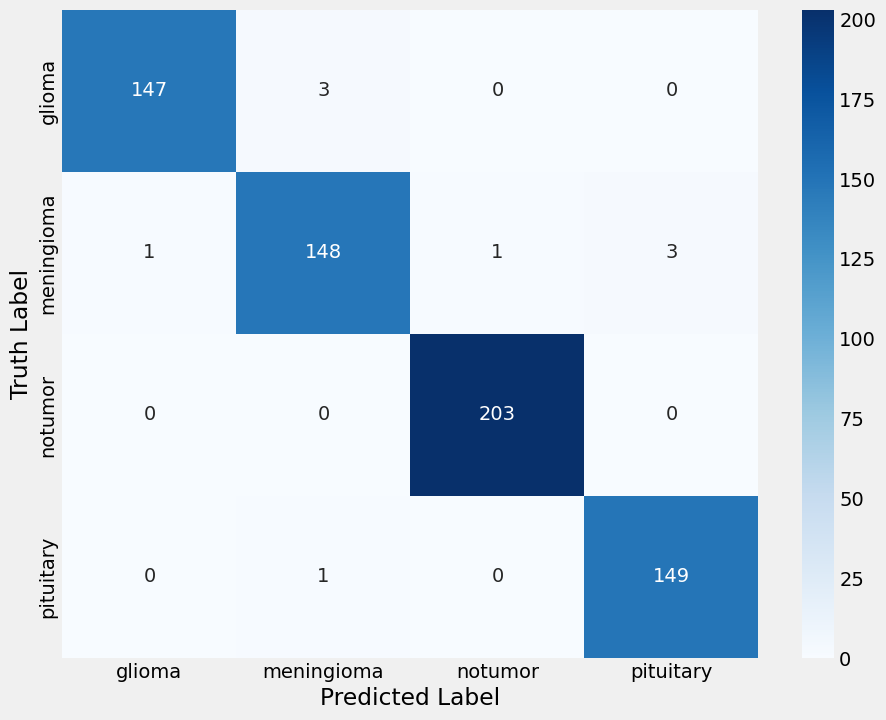

In [17]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [18]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       150
           1       0.97      0.97      0.97       153
           2       1.00      1.00      1.00       203
           3       0.98      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



# **Feature Extraction From The Flatten Layer**

In [19]:
for layer in model.layers:
    print(layer.name)

input_layer
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand

In [21]:
data_dir = "/kaggle/input/brain-tumor-mri-dataset/"
train_path = os.path.join(data_dir, "Training")
test_path = os.path.join(data_dir, "Testing")
img_size = (224, 224)
batch_size = 16  # Small batch size to reduce memory usage
num_classes = 4

# Load all images and labels into memory
all_images = []
all_labels = []
class_names = sorted(os.listdir(train_path))  # ['glioma', 'meningioma', 'notumor', 'pituitary']
print("Loading images...")
for class_idx, class_name in enumerate(class_names):
    train_class_path = os.path.join(train_path, class_name)
    for img_name in os.listdir(train_class_path):
        img_path = os.path.join(train_class_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        all_images.append(img_array)
        all_labels.append(class_idx)
    test_class_path = os.path.join(test_path, class_name)
    for img_name in os.listdir(test_class_path):
        img_path = os.path.join(test_class_path, img_name)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        all_images.append(img_array)
        all_labels.append(class_idx)

# Convert to NumPy arrays
all_images = np.array(all_images, dtype='float16')
all_labels = np.array(all_labels)
print(f"Loaded {all_images.shape[0]} images with shape {all_images.shape[1:]}")

Loading images...
Loaded 7023 images with shape (224, 224, 3)


In [22]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

Training set: 5618 images
Test set: 1405 images


In [24]:
import gc
del all_images, all_labels


In [25]:
gc.collect()

14316

In [26]:
feature_extractor = Model(inputs=model.input, outputs=model.layers[-5].output)

In [27]:
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step


# **Additional Procesasing On Extracted Features To be Fed to SVC**

Scaling

In [28]:
# Scale the features
scaler = StandardScaler()
X_train_features = scaler.fit_transform(train_features)
X_test_features = scaler.transform(test_features)

Feature Selection Using Various Methods

In [29]:
rf_feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selector.fit(X_train_features, y_train)
selector = SelectFromModel(rf_feature_selector, threshold="median", prefit=True)
X_train_selected = selector.transform(X_train_features)
X_test_selected = selector.transform(X_test_features)
print(f"Random Forest Reduced Shape: {X_train_selected.shape}")

# Free memory
del train_features, test_features, X_train_features, X_test_features
gc.collect()

Random Forest Reduced Shape: (5618, 640)


1122

In [30]:
methods = {
    'Random Forest': X_train_selected,
    'Decision Trees': None,
    'Z-score': None,
    'Random Forest Gini': None
}

In [31]:
# Decision Trees Feature Selection
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_selected, y_train)
dt_importances = dt.feature_importances_
dt_indices = np.argsort(dt_importances)[::-1][:1000]
methods['Decision Trees'] = X_train_selected[:, dt_indices]

In [32]:
# Z-score Feature Selection
z_scores = np.abs(zscore(X_train_selected, axis=0))
mean_z_scores = np.mean(z_scores, axis=0)
z_indices = np.argsort(mean_z_scores)[::-1][:1000]
methods['Z-score'] = X_train_selected[:, z_indices]

In [33]:
# Random Forest Gini Feature Selection
rf_gini = RandomForestClassifier(n_estimators=100, random_state=42)
rf_gini.fit(X_train_selected, y_train)
rf_gini_importances = rf_gini.feature_importances_
rf_gini_indices = np.argsort(rf_gini_importances)[::-1][:1000]
methods['Random Forest Gini'] = X_train_selected[:, rf_gini_indices]

In [34]:
results = {}
for method, X_train_method in methods.items():
    X_test_method = (X_test_selected[:, rf_gini_indices] if method == 'Random Forest Gini'
                     else X_test_selected[:, dt_indices] if method == 'Decision Trees'
                     else X_test_selected[:, z_indices] if method == 'Z-score'
                     else X_test_selected)
    svm = SVC(kernel='rbf', random_state=42, class_weight='balanced')
    svm.fit(X_train_method, y_train)
    y_pred = svm.predict(X_test_method)
    accuracy = accuracy_score(y_test, y_pred)
    results[method] = accuracy
    print(f"{method} SVM Accuracy: {accuracy:.4f}")

Random Forest SVM Accuracy: 0.9950
Decision Trees SVM Accuracy: 0.9950
Z-score SVM Accuracy: 0.9950
Random Forest Gini SVM Accuracy: 0.9950


In [35]:
best_method = max(results, key=results.get)
X_train_best = methods[best_method]
X_test_best = (X_test_selected[:, rf_gini_indices] if best_method == 'Random Forest Gini'
               else X_test_selected[:, dt_indices] if best_method == 'Decision Trees'
               else X_test_selected[:, z_indices] if best_method == 'Z-score'
               else X_test_selected)

PCA

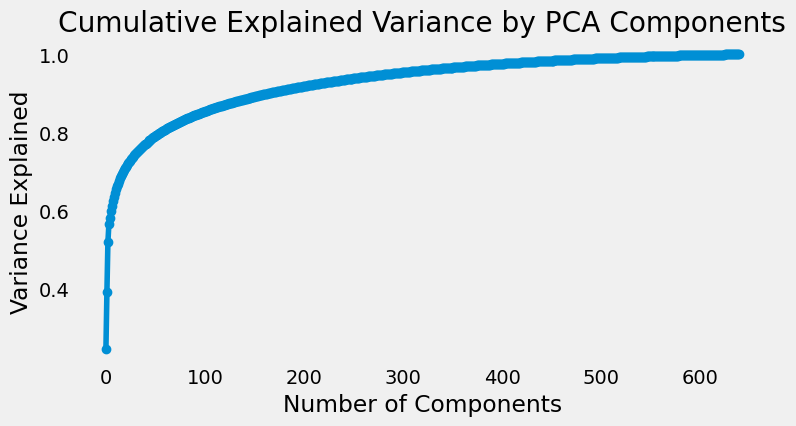

Optimal PCA components: 288


In [36]:
# Determine optimal PCA components
pca = PCA()
pca.fit(X_train_best)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.grid()
plt.savefig('/kaggle/working/pca_elbow.png')
plt.show()
plt.close()

# Choose optimal components (e.g., where variance > 95%)
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal PCA components: {optimal_components}")

# Apply PCA
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train_best)
X_test_pca = pca.transform(X_test_best)


# **SVC Hyperparameter Tuning Using Standard And Optimized Approaches**

**Standard GridSearch SVM**

In [39]:
# Hyperparameter Tuning for SVM
start_time_standard = time.time()
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.001]}
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability = True), param_grid, cv=3)
grid.fit(X_train_pca, y_train)
end_time_standard = time.time()
print("Best SVM Parameters:", grid.best_params_)
svm = grid.best_estimator_
print(f"\nStandard GridSearchCV Complete.")
time_standard = end_time_standard - start_time_standard
print(f"Time taken: {time_standard:.2f} seconds")
# Train and evaluate final SVM|
svm.fit(X_train_pca, y_train)
y_pred_final = svm.predict(X_test_pca)
final_accuracy = accuracy_score(y_test, y_pred_final)

print("Final SVM (Std.) Accuracy with Best Method + PCA:", final_accuracy)
print("Final SVM Classification Report:\n", classification_report(y_test, y_pred_final, target_names=class_names))

Best SVM Parameters: {'C': 10, 'gamma': 0.001}

Standard GridSearchCV Complete.
Time taken: 65.69 seconds
Final SVM (Std.) Accuracy with Best Method + PCA: 0.994306049822064
Final SVM Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       324
  meningioma       0.98      0.99      0.99       329
     notumor       1.00      1.00      1.00       400
   pituitary       1.00      0.99      1.00       352

    accuracy                           0.99      1405
   macro avg       0.99      0.99      0.99      1405
weighted avg       0.99      0.99      0.99      1405



**Accelerated GridSearch SVM**

In [40]:
print("\n Accelerated Grid Search (Fayed & Atiya)")

def accelerated_grid_search(X, y, param_grid, cv=3):
    best_score = -1
    best_params = {}
    
    # Sort C values in ascending order
    c_values = sorted(param_grid['C'])
    other_params = {k: v for k, v in param_grid.items() if k != 'C'}
    
    current_X = X
    current_y = y
    support_indices = np.arange(len(y)) # Start with all indices
    
    total_fits = 0
    
    for c_val in c_values:
        print(f"\nProcessing C = {c_val} with {len(support_indices)} data points...")
        # Create a temporary grid for this C value
        temp_grid = {'C': [c_val], **other_params}
        
        # Use standard GridSearchCV on the reduced dataset
        temp_svm = SVC(kernel='rbf', probability=True, random_state=42)
        temp_search = GridSearchCV(temp_svm, temp_grid, cv=cv, n_jobs=-1, verbose=0)
        temp_search.fit(current_X, current_y)
        
        total_fits += len(temp_search.cv_results_['params']) * cv
        
        # Update best score and params if improved
        if temp_search.best_score_ > best_score:
            best_score = temp_search.best_score_
            best_params = temp_search.best_params_
            print(f"  New best score: {best_score:.4f} with params: {best_params}")
        
        # Pruning Step: Find support vectors from the best model for this C
        best_estimator_for_c = temp_search.best_estimator_
        sv_indices_local = best_estimator_for_c.support_
        
        # Map local indices back to original indices
        support_indices = support_indices[sv_indices_local]
        
        # Update dataset for the next iteration
        current_X = X[support_indices]
        current_y = y[support_indices]
        
        if len(support_indices) == 0:
            print("Warning: No support vectors found. Stopping pruning.")
            break
            
    print(f"\nAccelerated search finished. Total model fits (approx): {total_fits}")
    return best_params, best_score

# Perform Accelerated Grid Search
print("Starting accelerated GridSearchCV...")
start_time_accelerated = time.time()
best_params_accelerated, best_score_accelerated = accelerated_grid_search(X_train_pca, y_train, param_grid, cv=3)
end_time_accelerated = time.time()
time_accelerated = end_time_accelerated - start_time_accelerated

print(f"\nAccelerated GridSearchCV Complete.")
print(f"Time taken: {time_accelerated:.2f} seconds")
print(f"Best Parameters: {best_params_accelerated}")
print(f"Best Cross-validation Score: {best_score_accelerated:.4f}")

# Train final model with best params from accelerated search
svm_accelerated_best = SVC(**best_params_accelerated, kernel='rbf', probability=True, random_state=42)
svm_accelerated_best.fit(X_train_pca, y_train)
accuracy_accelerated = accuracy_score(y_test, svm_accelerated_best.predict(X_test_pca))
print(f"Test Accuracy with accelerated best params: {accuracy_accelerated * 100:.2f}%")

# Final chosen model for XAI
final_svm_model = svm_accelerated_best
final_accuracy = accuracy_accelerated
final_params = best_params_accelerated


--- Accelerated Grid Search (Fayed & Atiya) --- 
Starting accelerated GridSearchCV...

Processing C = 0.1 with 5618 data points...
  New best score: 0.9920 with params: {'C': 0.1, 'gamma': 'scale'}

Processing C = 1 with 1000 data points...

Processing C = 10 with 556 data points...

Accelerated search finished. Total model fits (approx): 27

Accelerated GridSearchCV Complete.
Time taken: 23.61 seconds
Best Parameters: {'C': 0.1, 'gamma': 'scale'}
Best Cross-validation Score: 0.9920
Test Accuracy with accelerated best params: 99.22%



Comparison of Grid Search Methods Less is Better
Standard GridSearchCV Time: 65.69 seconds
Accelerated GridSearch Time: 23.61 seconds
Time Difference (Standard - Accelerated): 42.08 seconds
Standard GridSearchCV Accuracy: 99.22%
Accelerated GridSearch Accuracy: 99.22%
Accuracy Difference (Standard - Accelerated): 0.00%


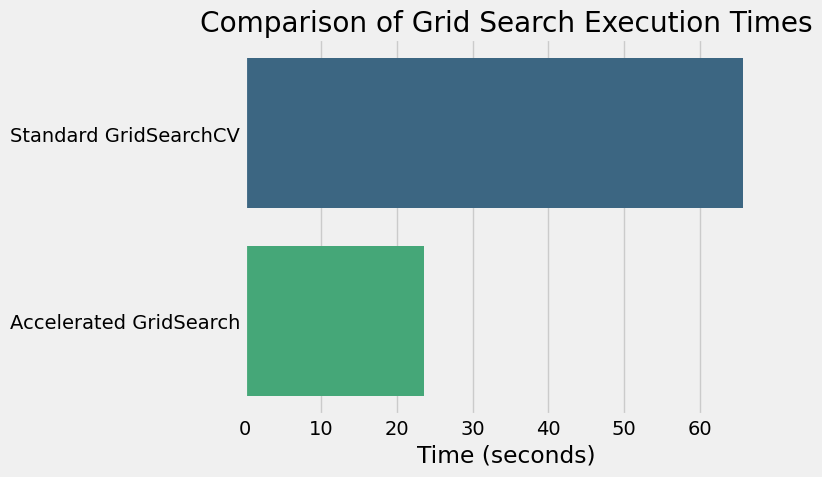

In [53]:
print("\nComparison of Grid Search Methods Less is Better")
print(f"Standard GridSearchCV Time: {time_standard:.2f} seconds")
print(f"Accelerated GridSearch Time: {time_accelerated:.2f} seconds")
print(f"Time Difference (Standard - Accelerated): {(time_standard - time_accelerated):.2f} seconds")
print(f"Standard GridSearchCV Accuracy: {final_accuracy * 100:.2f}%")
print(f"Accelerated GridSearch Accuracy: {accuracy_accelerated * 100:.2f}%")
print(f"Accuracy Difference (Standard - Accelerated): {(final_accuracy - accuracy_accelerated) * 100:.2f}%")

# Visualize the time comparison
plt.figure(figsize=(8, 5))
methods = ['Standard GridSearchCV', 'Accelerated GridSearch']
times = [time_standard, time_accelerated]
sns.barplot(x=times, y=methods, palette='viridis')
plt.xlabel('Time (seconds)')
plt.title('Comparison of Grid Search Execution Times')
plt.tight_layout()
plt.show()

# **Final Analysis of The Results and Interpretability and Explanability Techniques**

**AUC-ROC Curve for Final Accelerated SVM**

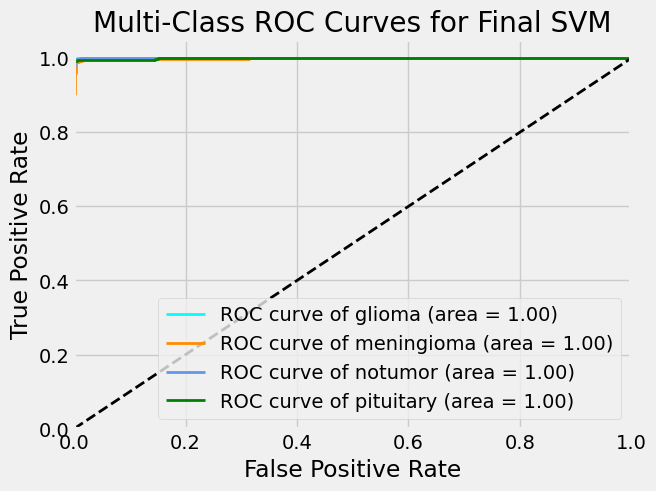

In [41]:
y_score = svm_accelerated_best.decision_function(X_test_pca)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves for Final SVM')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/multi_class_roc_curves.png')
plt.show()
plt.close()

Area under the curve is 1 which means the model is working perfectly giving impressive predictions in terms of accuracy|

**LIME Explanations (Local Interpretability)**

LIME Explanations for Selected Test Instances:

Explanation for test instance 0 (True label: meningioma, Predicted: meningioma)
PCA_1 <= -10.38: 0.3679
PCA_2 <= -6.09: 0.1280
PCA_4 > 2.52: 0.1139
PCA_3 <= -5.78: 0.1117
-0.01 < PCA_82 <= 0.55: 0.0270


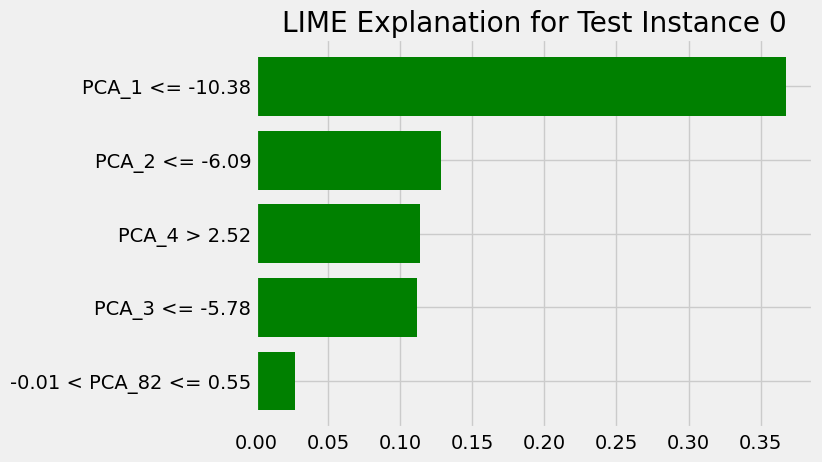


Explanation for test instance 1 (True label: meningioma, Predicted: meningioma)
PCA_1 <= -10.38: 0.3511
PCA_3 <= -5.78: 0.1087
PCA_4 <= -3.77: -0.1018
-0.33 < PCA_206 <= -0.01: -0.0276
PCA_271 <= -0.28: 0.0275


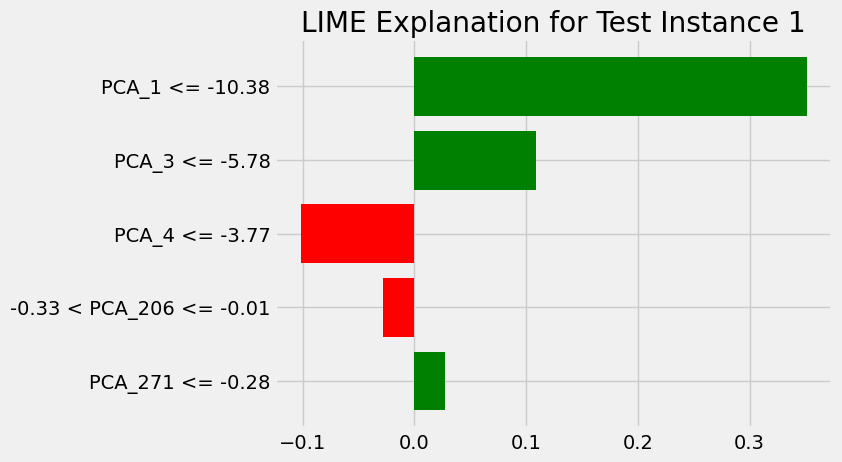


Explanation for test instance 2 (True label: glioma, Predicted: glioma)
PCA_1 > 6.49: -0.2595
PCA_2 > 0.73: -0.2570
PCA_4 > 2.52: 0.1189
-4.02 < PCA_3 <= 1.46: 0.0539
-0.01 < PCA_86 <= 0.49: 0.0296


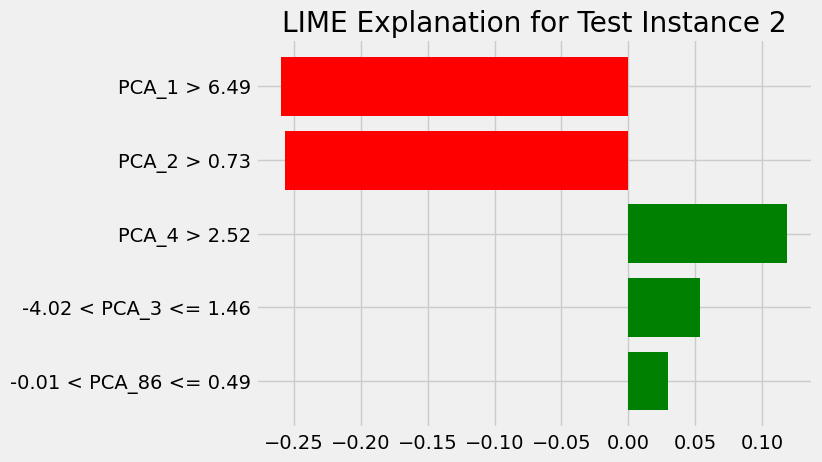

In [43]:
# Create feature names for PCA components
feature_names = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]

# Initialize LIME explainer for tabular data
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_pca,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    random_state=42
)

# Explain a few test instances (e.g., first 3 test samples)
print("LIME Explanations for Selected Test Instances:")
for idx in range(min(3, len(X_test_pca))):
    exp = lime_explainer.explain_instance(
        data_row=X_test_pca[idx],
        predict_fn=svm_accelerated_best.predict_proba,
        num_features=5
    )
    print(f"\nExplanation for test instance {idx} (True label: {class_names[y_test[idx]]}, Predicted: {class_names[y_pred_final[idx]]})")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight:.4f}")
    # Plot the explanation
    exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Test Instance {idx}')
    plt.show()


LIME Interpretations for SVM Predictions

Test Instance 0 (True: Meningioma, Predicted: Meningioma)





PCA_1 <= -10.38 (0.3679): Low PCA_1 strongly supports meningioma, likely capturing key tumor patterns.



PCA_2 <= -6.09 (0.1280): Low PCA_2 reinforces meningioma prediction.



PCA_4 > 2.52 (0.1139): High PCA_4 supports meningioma, possibly tumor boundaries.



PCA_3 <= -5.78 (0.1117): Low PCA_3 aids meningioma classification.



PCA_82 in [-0.01, 0.55] (0.0270): Minor positive contribution from PCA_82.



Summary: Low PCA_1, PCA_2, PCA_3, and high PCA_4 drive correct meningioma prediction.

Test Instance 1 (True: Meningioma, Predicted: Meningioma)





PCA_1 <= -10.38 (0.3511): Low PCA_1 is primary driver for meningioma.



PCA_3 <= -5.78 (0.1087): Low PCA_3 supports meningioma.



PCA_4 <= -3.77 (-0.1018): Low PCA_4 reduces meningioma likelihood but is outweighed.



PCA_206 in [-0.33, -0.01] (-0.0276): Slightly against meningioma.



PCA_271 <= -0.28 (0.0275): Minor support for meningioma.



Summary: Low PCA_1 and PCA_3 ensure correct meningioma prediction despite negative PCA_4.

Test Instance 2 (True: Glioma, Predicted: Glioma)





PCA_1 > 6.49 (-0.2595): High PCA_1 reduces glioma likelihood, contrasting meningioma.



PCA_2 > 0.73 (-0.2570): High PCA_2 opposes glioma prediction.



PCA_4 > 2.52 (0.1189): High PCA_4 supports glioma, possibly shared with meningioma.



PCA_3 in [-4.02, 1.46] (0.0539): Moderate PCA_3 aids glioma prediction.



PCA_86 in [-0.01, 0.49] (0.0296): Minor support for glioma.



Summary: High PCA_4 and moderate PCA_3 drive correct glioma prediction, despite high PCA_1 and PCA_2 opposing.

**SHAP**

  0%|          | 0/50 [00:00<?, ?it/s]


SHAP Summary Plot (Global Feature Importance):


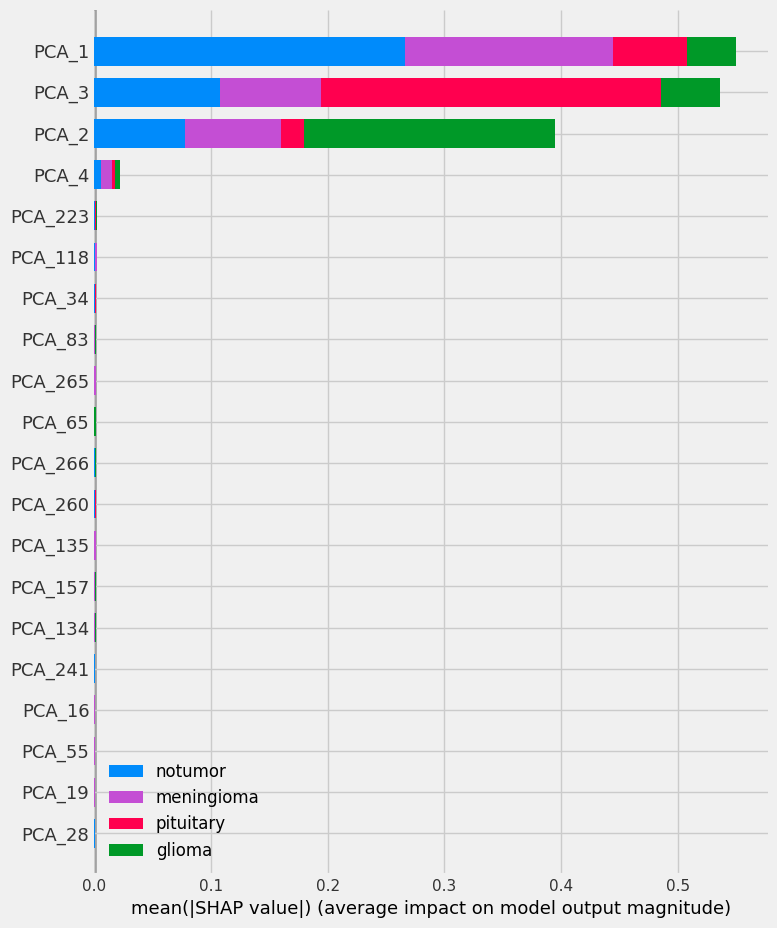


SHAP Explanation for Test Instance 0:


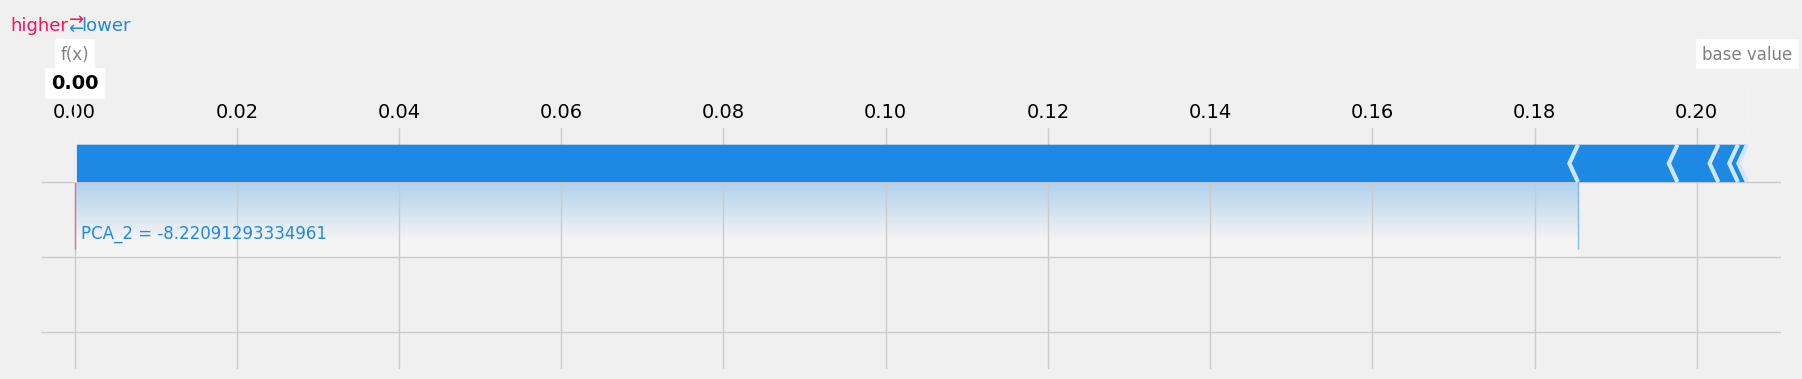

In [45]:
# SHAP Explanations (Local and Global Interpretability)
background_data = X_train_pca[np.random.choice(X_train_pca.shape[0], 100, replace=False)]
shap_explainer = shap.KernelExplainer(svm_accelerated_best.predict_proba, background_data)
shap_values = shap_explainer.shap_values(X_test_pca[:50], nsamples=150)
print("\nSHAP Summary Plot (Global Feature Importance):")
shap.summary_plot(shap_values, X_test_pca[:50], feature_names=feature_names, class_names=class_names, plot_type="bar")
plt.show()
print("\nSHAP Explanation for Test Instance 0:")
shap.force_plot(shap_explainer.expected_value[0], shap_values[0][0], X_test_pca[0], feature_names=feature_names, matplotlib=True)
plt.show()

Interpretation of SHAP Summary Plot





Top Features:





PCA_1: Highest overall importance, with significant contributions across all classes (blue: notumor, purple: meningioma, red: pituitary, green: glioma). Indicates it captures a primary pattern differentiating tumor types.



PCA_3: Second most important, dominated by glioma (green), suggesting it strongly influences glioma classification.



PCA_2: High importance, with a strong glioma (green) influence, indicating a key feature for glioma detection.



Class-Specific Insights:





Glioma (Green): Dominates PCA_2 and PCA_3, implying these components are critical for identifying glioma tumors, possibly related to unique MRI characteristics.



Pituitary (Red): Notable in PCA_3, suggesting it helps distinguish pituitary tumors.



Meningioma (Purple): Present in PCA_1 and PCA_3, indicating these components aid in meningioma classification.



Notumor (Blue): Contributes to PCA_1, reflecting its role in identifying non-tumor cases.



Lower-Order Components: PCA_4, PCA_223, and others have minimal impact, with contributions spread across classes, suggesting higher-order PCA components are less discriminative.



Summary: PCA_1 is the most influential feature globally, affecting all classes, while PCA_2 and PCA_3 are particularly important for glioma. The varying color distributions highlight how different PCA components capture class-specific patterns in the MRI data.

**PDP**


Partial Dependence Plots for Top PCA Components:


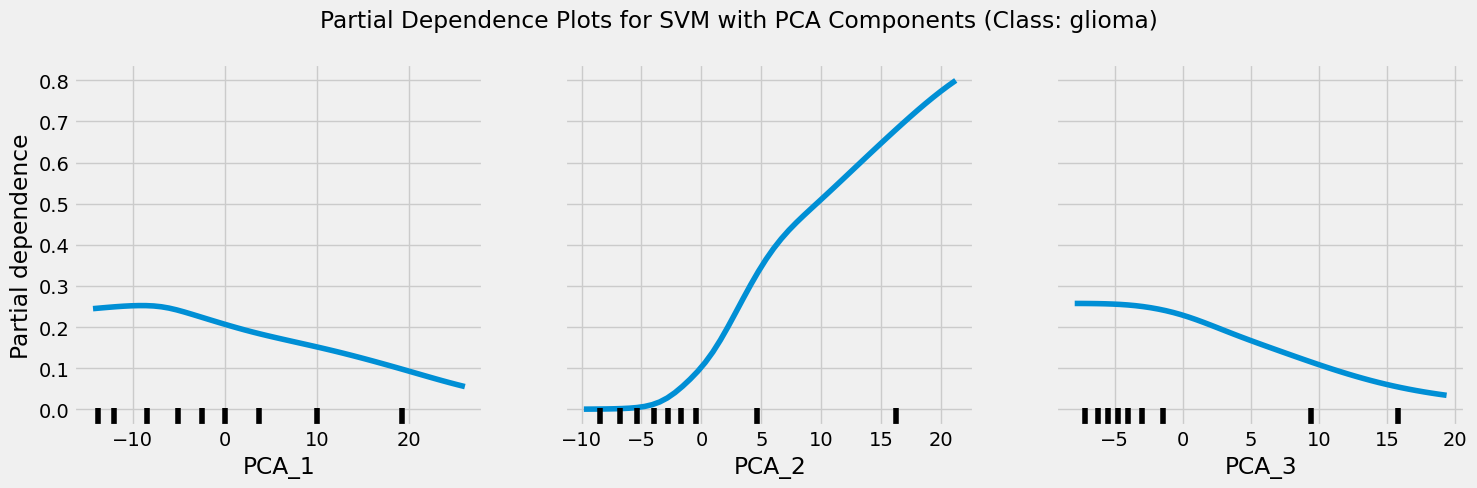

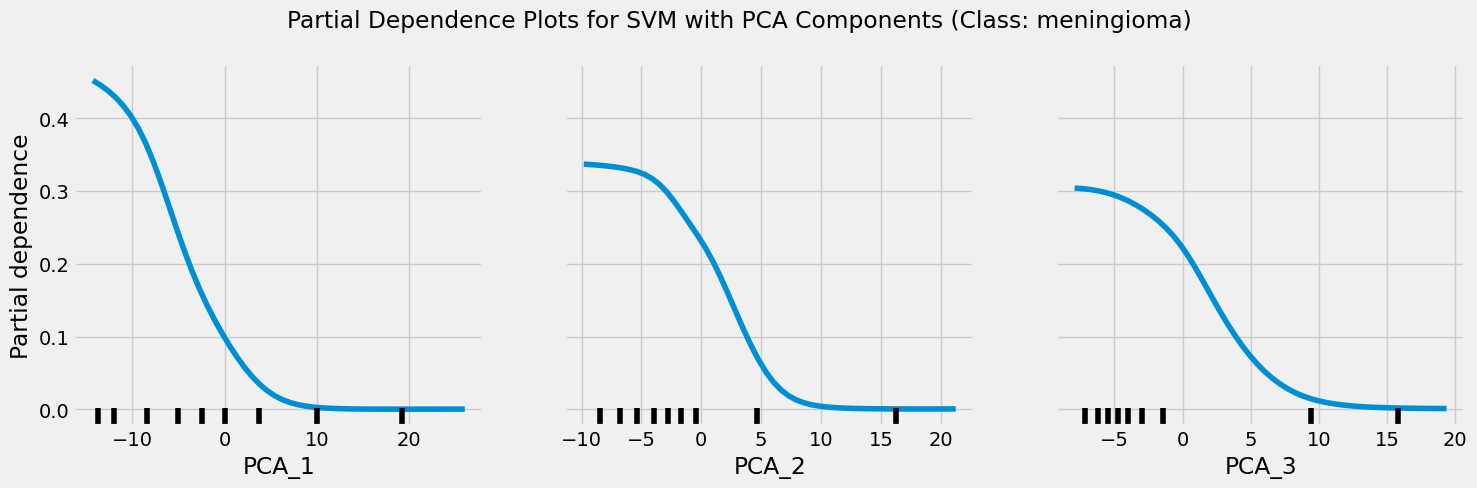

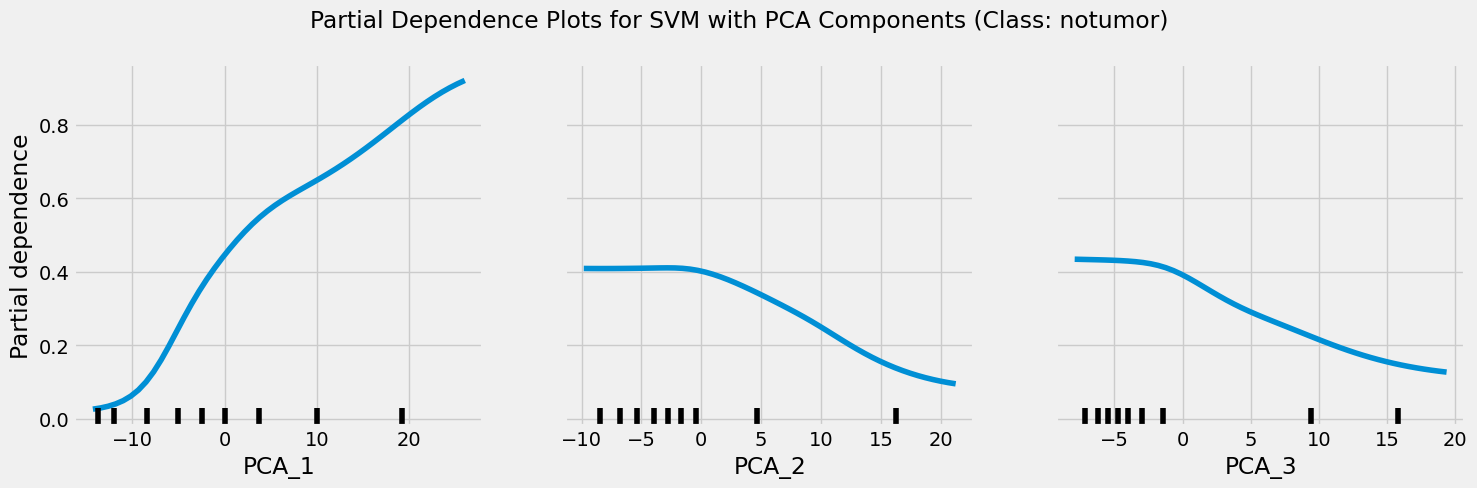

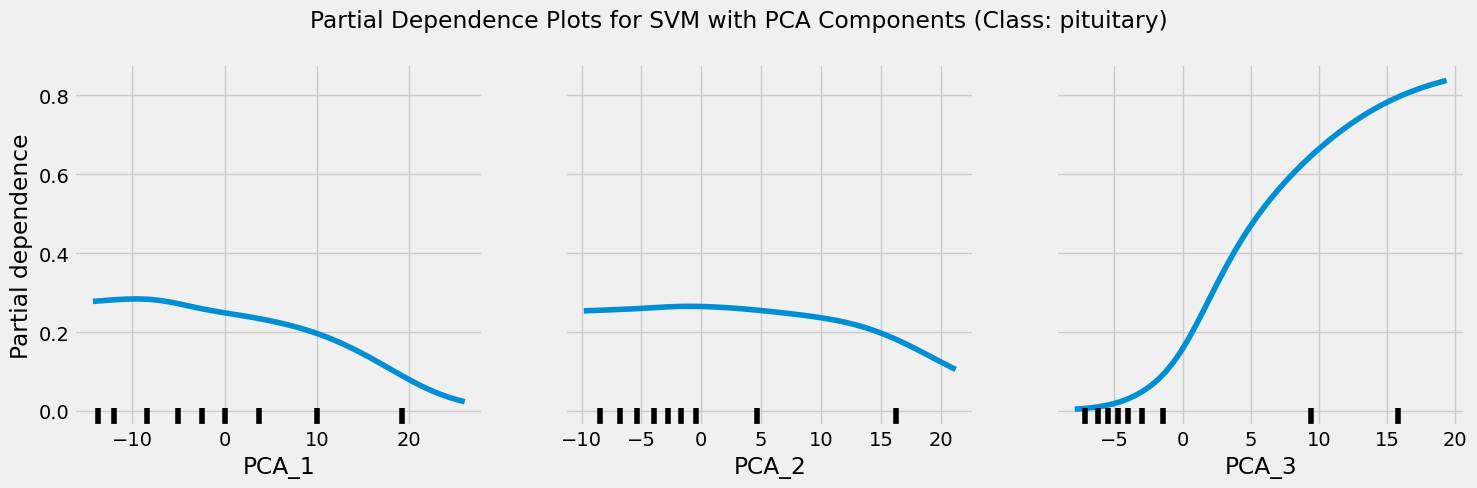

In [47]:
print("\nPartial Dependence Plots for Top PCA Components:")
features_to_plot = [0, 1, 2]  # Correspond to PCA_1, PCA_2, PCA_3
for class_idx, class_name in enumerate(class_names):
    fig, ax = plt.subplots(figsize=(15, 5))
    PartialDependenceDisplay.from_estimator(
        estimator=svm_accelerated_best,
        X=X_train_pca,
        features=features_to_plot,
        feature_names=feature_names,
        target=class_idx,  # Specify the class index for multi-class
        grid_resolution=50,
        ax=ax
    )
    plt.suptitle(f'Partial Dependence Plots for SVM with PCA Components (Class: {class_name})')
    plt.tight_layout()
    plt.show()

Interpretation of Partial Dependence Plots for SVM

Class: Glioma





PCA_1: Decreases from 0.3 to 0.1 as PCA_1 increases from -10 to 20. Higher PCA_1 values reduce glioma likelihood.



PCA_2: Rises sharply from 0 to 0.8 as PCA_2 increases from -10 to 20. Higher PCA_2 strongly favors glioma.



PCA_3: Slightly decreases from 0.3 to 0.1 as PCA_3 increases from -5 to 20. Higher PCA_3 slightly reduces glioma likelihood.

Class: Meningioma





PCA_1: Drops from 0.4 to 0 as PCA_1 increases from -10 to 20. Low PCA_1 strongly favors meningioma.



PCA_2: Decreases from 0.3 to 0 as PCA_2 increases from -10 to 20. Low PCA_2 favors meningioma.



PCA_3: Drops from 0.3 to 0 as PCA_3 increases from -5 to 20. Low PCA_3 favors meningioma.

Class: Notumor





PCA_1: Rises from 0 to 0.8 as PCA_1 increases from -10 to 20. High PCA_1 strongly favors notumor.



PCA_2: Slightly decreases from 0.4 to 0.2 as PCA_2 increases from -10 to 20. Higher PCA_2 slightly reduces notumor likelihood.



PCA_3: Decreases from 0.4 to 0.2 as PCA_3 increases from -5 to 20. Higher PCA_3 reduces notumor likelihood.

Class: Pituitary





PCA_1: Decreases from 0.4 to 0.1 as PCA_1 increases from -10 to 20. Low PCA_1 favors pituitary.



PCA_2: Slightly decreases from 0.3 to 0.1 as PCA_2 increases from -10 to 20. Higher PCA_2 reduces pituitary likelihood.



PCA_3: Rises sharply from 0 to 0.8 as PCA_3 increases from -5 to 20. High PCA_3 strongly favors pituitary.

Summary





PCA_1: High values favor notumor, low values favor meningioma and pituitary, mixed for glioma.



PCA_2: High values strongly favor glioma, low values favor meningioma.



PCA_3: High values favor pituitary, low values favor meningioma, minimal impact on glioma and notumor.

# 

**Permutation Importance for PCA Components**

In [ ]:
perm_importance = permutation_importance(svm, X_test_pca, y_test, n_repeats=10, random_state=42, n_jobs=-1)
# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()
# Plot permutation importance
plt.figure(figsize=(80, 24))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], xerr=perm_importance.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance (Mean Decrease in Accuracy)')
plt.title('Permutation Importance of PCA Components for SVM')
plt.tight_layout()
plt.show()
# Print permutation importance values
print("Permutation Importance Values:")
for i in sorted_idx[::-1]:  # Print in descending order
    print(f"{feature_names[i]}: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")

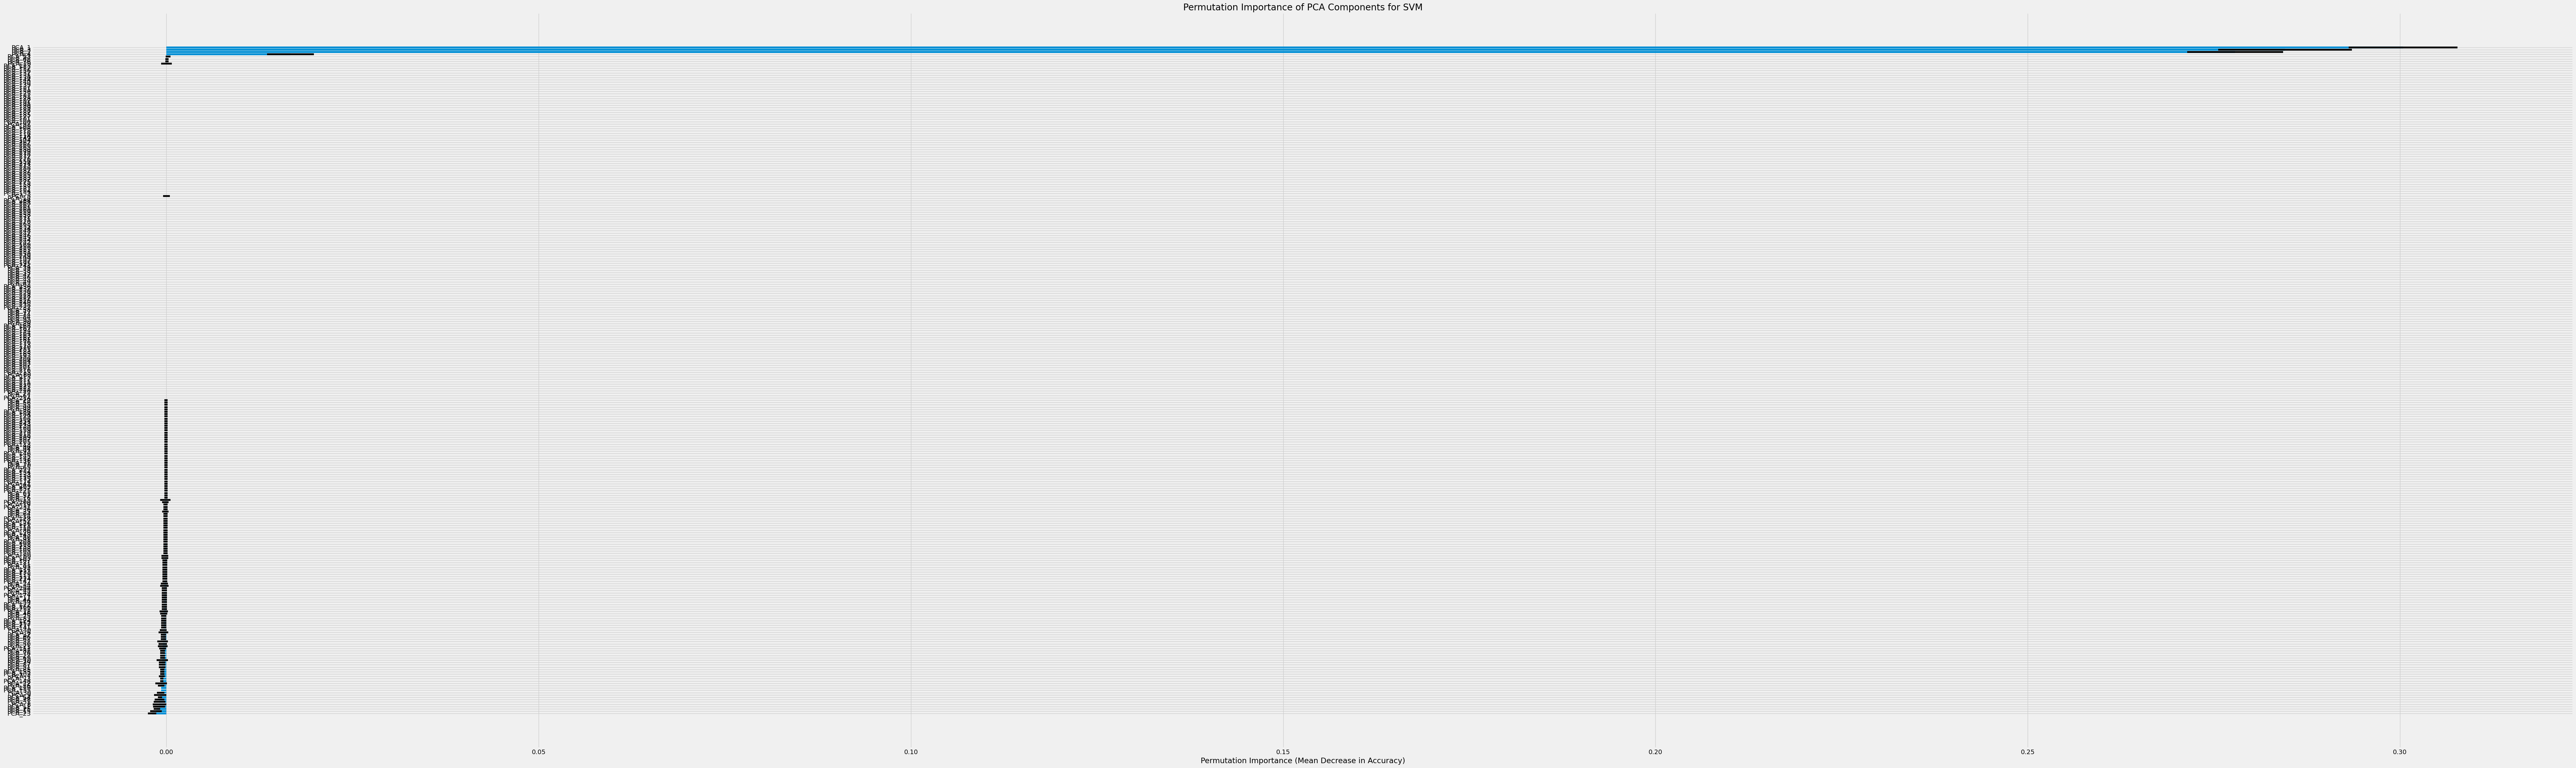

Permutation Importance Values:
PCA_1: 0.3004 ± 0.0073
PCA_3: 0.2846 ± 0.0090
PCA_2: 0.2779 ± 0.0064
PCA_4: 0.0167 ± 0.0031
PCA_53: 0.0002 ± 0.0003
PCA_68: 0.0001 ± 0.0002
PCA_76: 0.0001 ± 0.0002
PCA_20: 0.0000 ± 0.0007
PCA_123: 0.0000 ± 0.0000
PCA_122: 0.0000 ± 0.0000
PCA_136: 0.0000 ± 0.0000
PCA_132: 0.0000 ± 0.0000
PCA_131: 0.0000 ± 0.0000
PCA_130: 0.0000 ± 0.0000
PCA_144: 0.0000 ± 0.0000
PCA_140: 0.0000 ± 0.0000
PCA_139: 0.0000 ± 0.0000
PCA_137: 0.0000 ± 0.0000
PCA_151: 0.0000 ± 0.0000
PCA_150: 0.0000 ± 0.0000
PCA_125: 0.0000 ± 0.0000
PCA_181: 0.0000 ± 0.0000
PCA_178: 0.0000 ± 0.0000
PCA_192: 0.0000 ± 0.0000
PCA_191: 0.0000 ± 0.0000
PCA_190: 0.0000 ± 0.0000
PCA_189: 0.0000 ± 0.0000
PCA_188: 0.0000 ± 0.0000
PCA_187: 0.0000 ± 0.0000
PCA_185: 0.0000 ± 0.0000
PCA_127: 0.0000 ± 0.0000
PCA_101: 0.0000 ± 0.0000
PCA_100: 0.0000 ± 0.0000
PCA_97: 0.0000 ± 0.0000
PCA_109: 0.0000 ± 0.0000
PCA_106: 0.0000 ± 0.0000
PCA_118: 0.0000 ± 0.0000
PCA_116: 0.0000 ± 0.0000
PCA_114: 0.0000 ± 0.0000
PCA_149

Interpretation of Permutation Importance Values





Top Features:





PCA_1 (0.3004 ± 0.0073): Most important, significantly impacts model performance, likely capturing primary patterns in MRI data.



PCA_3 (0.2846 ± 0.0090): Second most important, also critical for classification, possibly distinguishing specific tumor types.



PCA_2 (0.2779 ± 0.0064): High importance, closely follows PCA_1 and PCA_3, indicating a key role in differentiation.



Mid-Tier Features:





PCA_4 (0.0167 ± 0.0031): Moderate importance, contributes to performance but far less than top features.



PCA_53, PCA_68, PCA_76 (0.0001–0.0002): Very low importance, minimal impact on model performance.



Negligible/Negative Features:





PCA_20 to PCA_287 (0.0000 or negative): Many higher-order components (e.g., PCA_123, PCA_266) have zero or negative importance, indicating they are irrelevant or slightly detrimental when permuted.



PCA_23 (-0.0019 ± 0.0006): Largest negative impact, suggesting permutation slightly improves performance, possibly due to noise.



Summary: The SVM model heavily relies on PCA_1, PCA_3, and PCA_2 for accurate classification, aligning with their high importance in distinguishing tumor types. PCA_4 has a smaller role, while most higher-order components (e.g., PCA_53 and beyond) are negligible or redundant, contributing little to the model's predictive power.